<a href="https://colab.research.google.com/github/rafsunsheikh/BT_in_IS_research_retionale_analysis/blob/main/DSR_in_BT_SLR_LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install numpy-2.3.1
!pip install gensim
!pip install pyLDAvis
!pip install wordcloud
# !pip install -U pip setuptools wheel
# !pip install -U spacy

  Using cached pyLDAvis-3.4.1-py3-none-any.whl.metadata (4.2 kB)
  Using cached funcy-2.0-py2.py3-none-any.whl.metadata (5.9 kB)
Using cached pyLDAvis-3.4.1-py3-none-any.whl (2.6 MB)
Using cached funcy-2.0-py2.py3-none-any.whl (30 kB)


In [ ]:
import pandas as pd
import numpy as np

import re
import string
from os import path
from PIL import Image

import os
os.path

#Gensim
import gensim
from gensim import corpora

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# spacy for lemmatization
import spacy

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


/usr/local/lib/python3.11/dist-packages/spacy/cli/_util.py:23: DeprecationWarning: Importing 'parser.split_arg_string' is deprecated, it will only be available in 'shell_completion' in Click 9.0.
  from click.parser import split_arg_string
/usr/local/lib/python3.11/dist-packages/weasel/util/config.py:8: DeprecationWarning: Importing 'parser.split_arg_string' is deprecated, it will only be available in 'shell_completion' in Click 9.0.
  from click.parser import split_arg_string


In [ ]:
# Import Dataset txt file - 305 research papers
file_path = "/content/Book1.xlsx"
data = pd.read_excel(file_path)

In [ ]:
data.head()

,Title,Abstract,Author Keywords,Index Keywords
0,Overcoming the Data Transparency Trade-Off: De...,Blockchain’s inherent characteristics render i...,Blockchain technology; Construction industry; ...,NaN
1,Blockchain-based digital rights management sys...,Initially designed to protect intellectual pro...,Blockchain; Decentralization; Design principle...,NaN
2,Blockchain-based digital product passport: des...,Digital product passports (DPPs) will become a...,blockchain; circular manufacturing; circular s...,Supply chains; Block-chain; Circular manufactu...
3,Toward Seamless Mobility-as-a-Service: Providi...,With growing awareness of sustainability and c...,Coopetition; Digital identity; Digital wallet;...,NaN
4,"SCeFSTA: Smart Contract enabled Fair, Secure, ...",The healthcare transport sector has progressed...,NaN,Blockchain; Cost effectiveness; Distributed le...


In [ ]:
#create a new dataframe from the data keeping only the columns "Title", "Abstract", "Author Keywords" and "Index Keywords"
data_text = data[['Title', 'Abstract', 'Author Keywords', 'Index Keywords']].copy()
data_text.head()

,Title,Abstract,Author Keywords,Index Keywords
0,Overcoming the Data Transparency Trade-Off: De...,Blockchain’s inherent characteristics render i...,Blockchain technology; Construction industry; ...,NaN
1,Blockchain-based digital rights management sys...,Initially designed to protect intellectual pro...,Blockchain; Decentralization; Design principle...,NaN
2,Blockchain-based digital product passport: des...,Digital product passports (DPPs) will become a...,blockchain; circular manufacturing; circular s...,Supply chains; Block-chain; Circular manufactu...
3,Toward Seamless Mobility-as-a-Service: Providi...,With growing awareness of sustainability and c...,Coopetition; Digital identity; Digital wallet;...,NaN
4,"SCeFSTA: Smart Contract enabled Fair, Secure, ...",The healthcare transport sector has progressed...,NaN,Blockchain; Cost effectiveness; Distributed le...


In [ ]:
# prompt: can I concat the data from each row and put them in a new column as "text"?

data_text['text'] = data_text.apply(lambda row: ' '.join(row.astype(str)), axis=1)
data_text.head()

,Title,Abstract,Author Keywords,Index Keywords,text
0,Overcoming the Data Transparency Trade-Off: De...,Blockchain’s inherent characteristics render i...,Blockchain technology; Construction industry; ...,NaN,Overcoming the Data Transparency Trade-Off: De...
1,Blockchain-based digital rights management sys...,Initially designed to protect intellectual pro...,Blockchain; Decentralization; Design principle...,NaN,Blockchain-based digital rights management sys...
2,Blockchain-based digital product passport: des...,Digital product passports (DPPs) will become a...,blockchain; circular manufacturing; circular s...,Supply chains; Block-chain; Circular manufactu...,Blockchain-based digital product passport: des...
3,Toward Seamless Mobility-as-a-Service: Providi...,With growing awareness of sustainability and c...,Coopetition; Digital identity; Digital wallet;...,NaN,Toward Seamless Mobility-as-a-Service: Providi...
4,"SCeFSTA: Smart Contract enabled Fair, Secure, ...",The healthcare transport sector has progressed...,NaN,Blockchain; Cost effectiveness; Distributed le...,"SCeFSTA: Smart Contract enabled Fair, Secure, ..."


In [ ]:
lda_data = data_text[['text']]
lda_data['index'] = lda_data.index
documents = lda_data


/tmp/ipython-input-4065784239.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lda_data['index'] = lda_data.index


In [ ]:
print(len(documents))
print(documents[:5])

348
                                                text  index
0  Overcoming the Data Transparency Trade-Off: De...      0
1  Blockchain-based digital rights management sys...      1
2  Blockchain-based digital product passport: des...      2
3  Toward Seamless Mobility-as-a-Service: Providi...      3
4  SCeFSTA: Smart Contract enabled Fair, Secure, ...      4


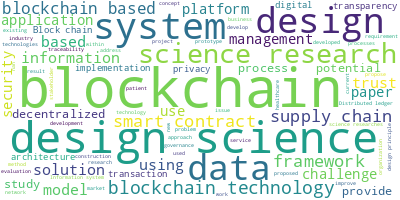

In [ ]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(documents['text'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=50000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [ ]:
# NLTK Stop words
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# function to remove stopwords
def remove_stopwords(text):
    textArr = text.split(' ')
    rem_text = " ".join([i for i in textArr if i not in stop_words])
    return rem_text

# remove stopwords from the text
documents['text']=documents['text'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/tmp/ipython-input-1904734973.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  documents['text']=documents['text'].apply(remove_stopwords)


In [ ]:
#Tokenize words and Clean-up text

import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'et', 'al', 'doi', 'abstract', 'clinical', 'ml', 'cid', 'data', 'using', 'http','machine learning', 'used', 'ieee','receiv', 'infer', 'significant', 'patients', 'heart', 'cancer', 'none', 'model', 'university', 'research', 'editor', 'covid', 'ai', 'journal', 'features', 'learning', 'medical', 'informatio', 'treatment', 'health', 'consultant', 'care', 'risk', 'response', 'failure', 'learning', 'features','machine', 'mds', 'based', 'imaging', 'lime', 'hc', 'methods', 'university', 'tle', 'patients', 'mri', 'org', 'temporal', 'vol',
                   'network', 'pe', 'ct', 'alk', 'test', 'non', 'pet', 'two', 'set', 'inr', 'https', 'ac', 'vp', 'moto', 'ckd', 'cad', 'med', 'set', 'may', 'time', 'also', 'table', 'images', 'high', 'site', 'na', 'hf', 'sites', 'chr', 'follow', 'image', 'asd', 'ados', 'social', 'items', 'user', 'food', 'rule', 'mobile', 'https', 'application', 'applications', 'new', 'early', 'process', 'jmir', 'full', 'ncr', 'one', 'med', 'plos', 'pone', 'fig', 'ts', 'line', 'number', 'pmid', 'pp', 'note', 'oa', 'vector', 'set', 'de', 'pd', 'word', 'auc', 'copd','iv'])
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc))
             if word not in stop_words] for doc in texts]
data = documents.text.values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['overcoming', 'transparency', 'trade', 'designing', 'blockchain', 'delivery', 'invoice', 'system', 'construction', 'industry', 'blockchain', 'inherent', 'characteristics', 'render', 'promising', 'solution', 'collaborative', 'supply', 'chain', 'networks', 'however', 'technology', 'still', 'faces', 'challenges', 'coopetition', 'sharing', 'business', 'blockchains', 'requires']


In [ ]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
from nltk.stem import PorterStemmer
stemmer=PorterStemmer()
stemmer.stem('numpang wifi stop gadget shopping')
'numpang wifi stop gadget shopping'

'numpang wifi stop gadget shopping'

In [ ]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [ ]:
doc = documents[documents['index'] == 213].values[0][0]
print('original document: ')
words = []
for word in doc.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc))

original document: 
['Taxonomy', 'digital', 'community', 'currency', 'platforms*', 'Community', 'currencies', 'used', 'pay', 'products', 'services', 'within', 'specific', 'groups', 'defined', 'geographical', 'boundaries', 'specific', 'common', 'interests.', 'Financial', 'crises,', 'social', 'emergence', 'developing', 'countries,', 'increased', 'access', 'digital', 'devices', 'stimulated', 'growing', 'number', 'communities', 'worldwide', 'develop', 'digital', 'currency', 'projects.', 'These', 'projects', 'use', 'technologies', 'ranging', 'traditional', 'plastic', 'cards', 'mobile', 'phones', 'blockchain', 'technologies.', 'Following', 'design', 'science', 'research', 'approach,', 'paper', 'analyzes', 'digital', 'community', 'currencies', '(DCCs)', 'developing', 'taxonomy', 'based', 'platform', 'architecture,', 'governance,', 'transactionality', 'virtuality.', 'By', 'investigating', '22', 'DCC', 'platforms', 'around', 'world,', '4', 'groups', 'distinguished:', 'local,', 'proprietary,', '

In [ ]:
# Do lemmatization keeping only noun, adj, verb, adv
def lemmatization(texts,allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
       output = []
       for sent in texts:
             doc = nlp(sent)
             output.append([token.lemma_ for token in doc if token.pos_ in allowed_postags ])
       return output

In [ ]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 3), (11, 1), (12, 2), (13, 3), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 4), (25, 2), (26, 1), (27, 1), (28, 4), (29, 1)]


In [ ]:
processed_docs = documents['text'].map(preprocess)
processed_docs[:50]

,text
0,"[overcom, data, transpar, trade, design, block..."
1,"[blockchain, base, digit, right, manag, system..."
2,"[blockchain, base, digit, product, passport, d..."
3,"[seamless, mobil, servic, provid, multimod, mo..."
4,"[scefsta, smart, contract, enabl, fair, secur,..."
5,"[hybrid, smart, detect, prevent, framework, sm..."
6,"[novel, framework, identifi, cybersecur, chall..."
7,"[design, govern, model, blockchain, base, trac..."
8,"[budgetari, control, adopt, consortium, blockc..."
9,"[formal, simul, token, aspect, blockchain, bas..."


In [ ]:
#Create the Dictionary and Corpus needed for Topic Modeling

dictionary = corpora.Dictionary(data_words)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in data_words]

In [ ]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=20, random_state=100,
                chunksize=1000, passes=50,iterations=100)

In [ ]:
lda_model.print_topics()

[(0,
  '0.032*"blockchain" + 0.019*"design" + 0.013*"business" + 0.012*"smart" + 0.010*"science" + 0.010*"construction" + 0.009*"energy" + 0.009*"power" + 0.008*"accounting" + 0.008*"payment"'),
 (1,
  '0.032*"blockchain" + 0.021*"design" + 0.014*"insurance" + 0.013*"healthcare" + 0.013*"science" + 0.013*"financial" + 0.011*"technology" + 0.011*"accounting" + 0.011*"smart" + 0.011*"reporting"'),
 (2,
  '0.031*"design" + 0.025*"blockchain" + 0.020*"trust" + 0.014*"supply" + 0.013*"chain" + 0.011*"science" + 0.011*"digital" + 0.010*"systems" + 0.007*"principles" + 0.007*"chains"'),
 (3,
  '0.030*"blockchain" + 0.028*"design" + 0.014*"science" + 0.011*"information" + 0.010*"business" + 0.009*"platform" + 0.008*"technology" + 0.008*"trust" + 0.008*"car" + 0.007*"water"'),
 (4,
  '0.035*"design" + 0.019*"systems" + 0.017*"science" + 0.016*"blockchain" + 0.010*"information" + 0.009*"system" + 0.009*"principles" + 0.008*"digital" + 0.008*"reporting" + 0.008*"technology"'),
 (5,
  '0.028*"bloc

In [ ]:
# Visualize the topics
#https://github.com/bmabey/pyLDAvis
#https://speakerdeck.com/bmabey/visualizing-topic-models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
19     0.077435  0.019027       1        1  22.764388
2      0.097730  0.025852       2        1   9.832335
5      0.069901 -0.015439       3        1   8.982514
15     0.068766  0.026895       4        1   8.393655
9      0.064304  0.031643       5        1   5.405315
11     0.036675  0.025010       6        1   5.268726
14     0.056879 -0.066403       7        1   4.304335
17     0.061785  0.004525       8        1   4.069077
13     0.075740 -0.021546       9        1   4.017286
3      0.012558  0.013575      10        1   3.966398
4      0.018163 -0.018652      11        1   3.648208
1      0.017755 -0.039951      12        1   3.603312
0      0.011064  0.003312      13        1   3.415972
8     -0.024647  0.041815      14        1   3.080057
10    -0.124605  0.207957      15        1   2.318328
12    -0.130922 -0.078325      16        1   1.601819
16    -0.075640 -0.047575      17        1   1.506771
7     -0.161017 -0.068680      18        1   1.300489
18    -0.103105  0.033560      19        1   1.278262
6     -0.048821 -0.076602      20        1   1.242752, topic_info=             Term         Freq        Total Category  logprob  loglift
10     blockchain  1700.000000  1700.000000  Default  30.0000  30.0000
61     management   346.000000   346.000000  Default  29.0000  29.0000
54    information   503.000000   503.000000  Default  28.0000  28.0000
30         design  1072.000000  1072.000000  Default  27.0000  27.0000
24   construction   189.000000   189.000000  Default  26.0000  26.0000
..            ...          ...          ...      ...      ...      ...
391      platform     2.830672   100.997227  Topic20  -5.3869   0.8133
562      reserved     2.646853    56.245884  Topic20  -5.4540   1.3315
90     technology     3.009065   465.776605  Topic20  -5.3258  -0.6542
101          case     2.749059   118.747546  Topic20  -5.4161   0.6221
450         study     2.830675   226.896652  Topic20  -5.3869   0.0039

[1380 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1477      4  0.883393   abaas
255       1  0.139279  access
255       2  0.087050  access
255       3  0.069640  access
255       4  0.069640  access
...     ...       ...     ...
1455     19  0.102763   world
5436     17  0.630332   write
2275      2  0.901737     wrs
5518      3  0.946210     xsc
3293     19  0.643621     xxv

[3590 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[20, 3, 6, 16, 10, 12, 15, 18, 14, 4, 5, 2, 1, 9, 11, 13, 17, 8, 19, 7])

In [ ]:
print('\nPerplexity: ', lda_model.log_perplexity(doc_term_matrix,total_docs=305))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=dictionary , coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.6319026190534025

Coherence Score:  0.28502523330215457


In [ ]:

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=data_words, start=2, limit=50, step=1)

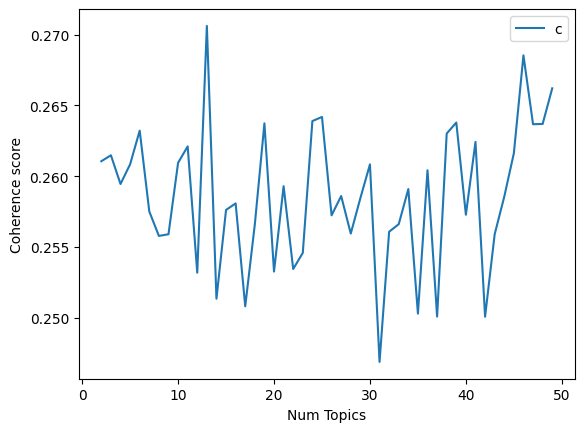

In [ ]:

# Show graph
limit=50; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()# Print the coherence scores

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2611
Num Topics = 3  has Coherence Value of 0.2615
Num Topics = 4  has Coherence Value of 0.2595
Num Topics = 5  has Coherence Value of 0.2608
Num Topics = 6  has Coherence Value of 0.2632
Num Topics = 7  has Coherence Value of 0.2575
Num Topics = 8  has Coherence Value of 0.2558
Num Topics = 9  has Coherence Value of 0.2559
Num Topics = 10  has Coherence Value of 0.2609
Num Topics = 11  has Coherence Value of 0.2621
Num Topics = 12  has Coherence Value of 0.2532
Num Topics = 13  has Coherence Value of 0.2706
Num Topics = 14  has Coherence Value of 0.2514
Num Topics = 15  has Coherence Value of 0.2576
Num Topics = 16  has Coherence Value of 0.2581
Num Topics = 17  has Coherence Value of 0.2508
Num Topics = 18  has Coherence Value of 0.2566
Num Topics = 19  has Coherence Value of 0.2637
Num Topics = 20  has Coherence Value of 0.2533
Num Topics = 21  has Coherence Value of 0.2593
Num Topics = 22  has Coherence Value of 0.2535
Num Topics = 23  has 

In [ ]:
# Select the model and print the topics
optimal_model = model_list[8]
model_topics = optimal_model.show_topics(formatted=False)
optimal_model.print_topics(num_words=20)

[(0,
  '0.021*"blockchain" + 0.012*"chain" + 0.010*"framework" + 0.010*"technology" + 0.009*"design" + 0.008*"system" + 0.008*"supply" + 0.008*"management" + 0.008*"smart" + 0.008*"science" + 0.007*"systems" + 0.006*"study" + 0.006*"information" + 0.005*"approach" + 0.005*"trust" + 0.005*"construction" + 0.005*"healthcare" + 0.005*"iot" + 0.004*"security" + 0.004*"digital"'),
 (1,
  '0.034*"blockchain" + 0.019*"design" + 0.016*"information" + 0.012*"science" + 0.010*"systems" + 0.007*"technology" + 0.006*"chain" + 0.006*"approach" + 0.006*"supply" + 0.005*"system" + 0.005*"digital" + 0.004*"smart" + 0.004*"decentralized" + 0.004*"solution" + 0.004*"ledger" + 0.004*"sharing" + 0.004*"distributed" + 0.004*"study" + 0.004*"management" + 0.004*"evaluation"'),
 (2,
  '0.037*"blockchain" + 0.019*"design" + 0.013*"information" + 0.010*"science" + 0.009*"smart" + 0.008*"system" + 0.007*"supply" + 0.007*"management" + 0.007*"technology" + 0.007*"systems" + 0.007*"digital" + 0.006*"decentralized

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.035181 -0.009826       1        1  27.899647
4     -0.006961 -0.002801       2        1  15.082605
2     -0.027422 -0.006994       3        1  14.715124
3     -0.024256  0.006122       4        1  14.068643
1     -0.010621 -0.012427       5        1   8.864066
8     -0.016649  0.044829       6        1   6.524331
0     -0.002577 -0.019808       7        1   5.968344
6      0.024368  0.015016       8        1   2.754569
9      0.044047 -0.050752       9        1   2.157968
5      0.055252  0.036639      10        1   1.964702, topic_info=            Term         Freq        Total Category  logprob  loglift
30        design  1086.000000  1086.000000  Default  30.0000  30.0000
10    blockchain  1748.000000  1748.000000  Default  29.0000  29.0000
90    technology   454.000000   454.000000  Default  28.0000  28.0000
34       digital   255.000000   255.000000  Default  27.0000  27.0000
54   information   504.000000   504.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
157        smart     2.833708   301.099826  Topic10  -5.8438  -0.7360
12      business     2.572718   200.808379  Topic10  -5.9405  -0.4276
86        supply     2.563824   291.047536  Topic10  -5.9439  -0.8022
261     approach     2.532311   253.635727  Topic10  -5.9563  -0.6769
450        study     2.431858   228.447252  Topic10  -5.9968  -0.6128

[780 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
4983      3  0.551901  accommodate
1194      1  0.164939   accounting
1194      2  0.070688   accounting
1194      3  0.329878   accounting
1194      4  0.235627   accounting
...     ...       ...          ...
1605      6  0.427920    workloads
5518      1  0.401243          xsc
5518      2  0.133748          xsc
5518      3  0.133748          xsc
5518      7  0.267496          xsc

[2055 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 5, 3, 4, 2, 9, 1, 7, 10, 6])

In [ ]:
#TFinding the dominant topic in each sentence

def format_topics_sentences(ldamodel=lda_model, corpus=doc_term_matrix, texts=data_words):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = pd.concat([sent_topics_df, pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]).to_frame().T], ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

     # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=doc_term_matrix, texts=data_words)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
# Show
df_dominant_topic.head(20)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2,0.9275,"blockchain, design, information, science, smar...","[overcoming, transparency, trade, designing, b..."
1,1,7,0.9932,"blockchain, design, science, management, frame...","[blockchain, digital, rights, management, syst..."
2,2,4,0.8887,"blockchain, design, science, information, tech...","[blockchain, digital, product, passport, desig..."
3,3,4,0.5045,"blockchain, design, science, information, tech...","[toward, seamless, mobility, service, providin..."
4,4,3,0.814,"design, blockchain, science, technology, syste...","[scefsta, smart, contract, enabled, fair, secu..."
5,5,2,0.7673,"blockchain, design, information, science, smar...","[hybrid, smart, iot, detection, prevention, fr..."
6,6,7,0.7323,"blockchain, design, science, management, frame...","[novel, framework, identify, cybersecurity, ch..."
7,7,7,0.5273,"blockchain, design, science, management, frame...","[designing, governance, blockchain, traceabili..."
8,8,0,0.8657,"blockchain, chain, framework, technology, desi...","[budgetary, control, adoption, consortium, blo..."
9,9,7,0.8036,"blockchain, design, science, management, frame...","[formalizing, simulating, token, aspects, bloc..."


In [ ]:
#Find the most representative document for each topic
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet,
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)],
                                            axis=0)

# Reset Index
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head(20)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0,0.9945,"blockchain, chain, framework, technology, design, system, supply, management, smart, science","[internet, things, system, integrated, blockchain, manage, patient, healthcare, sector, biggest,..."
1,1,0.9953,"blockchain, design, information, science, systems, technology, chain, approach, supply, system","[blockchain, improve, information, sharing, accuracy, onsite, assembly, modular, construction, o..."
2,2,0.9967,"blockchain, design, information, science, smart, system, supply, management, technology, systems","[control, personal, mhealth, blockchain, app, design, science, perspective, background, integrat..."
3,3,0.9955,"design, blockchain, science, technology, systems, chain, system, information, approach, management","[multichain, architecture, distributed, supply, chain, design, industry, fourth, industrial, rev..."
4,4,0.995,"blockchain, design, science, information, technology, digital, chain, supply, smart, approach","[self, aware, contract, decentralized, peer, peer, commerce, distributed, ledgers, blockchains, ..."
5,5,0.9955,"blockchain, design, market, science, management, technology, bitcoin, architecture, information,...","[exponentially, distributed, nonlinear, proof, work, saving, energy, preserving, bitcoin, mining..."
6,6,0.9953,"blockchain, design, technology, information, systems, science, management, healthcare, architect...","[secure, blockchain, framework, healthcare, records, management, systems, electronic, records, e..."
7,7,0.9966,"blockchain, design, science, management, framework, technology, chain, trust, information, systems","[decentralized, automated, contracting, system, blockchain, enabled, stakeholders, construction,..."
8,8,0.9953,"design, blockchain, real, science, technology, information, approach, smart, decentralized, estate","[blockchain, driven, framework, financing, credit, small, medium, sized, real, estate, enterpris..."
9,9,0.9947,"design, digital, blockchain, value, science, technology, information, systems, chain, distributed","[bc, eco, visual, tools, shared, understanding, pedagogical, approach, across, consortium, effec..."


In [ ]:
#Topic distribution across documents
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 5)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
pd.set_option('display.max_rows', None)
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,2,"blockchain, design, information, science, smart, system, supply, management, technology, systems",19.0,0.05460
1,7,"blockchain, design, science, management, framework, technology, chain, trust, information, systems",32.0,0.09195
2,4,"blockchain, design, science, information, technology, digital, chain, supply, smart, approach",50.0,0.14368
3,4,"blockchain, design, science, information, technology, digital, chain, supply, smart, approach",51.0,0.14655
4,3,"design, blockchain, science, technology, systems, chain, system, information, approach, management",54.0,0.15517
5,2,"blockchain, design, information, science, smart, system, supply, management, technology, systems",7.0,0.02011
6,7,"blockchain, design, science, management, framework, technology, chain, trust, information, systems",10.0,0.02874
7,7,"blockchain, design, science, management, framework, technology, chain, trust, information, systems",96.0,0.27586
8,0,"blockchain, chain, framework, technology, design, system, supply, management, smart, science",21.0,0.06034
9,7,"blockchain, design, science, management, framework, technology, chain, trust, information, systems",8.0,0.02299


In [ ]:
pd.set_option('display.max_rows', None)

In [ ]:
print(df_dominant_topics)

    Dominant_Topic  \
0                2   
1                7   
2                4   
3                4   
4                3   
5                2   
6                7   
7                7   
8                0   
9                7   
10               7   
11               4   
12               4   
13               7   
14               2   
15               4   
16               2   
17               3   
18               7   
19               7   
20               7   
21               3   
22               7   
23               4   
24               9   
25               4   
26               3   
27               1   
28               3   
29               8   
30               7   
31               1   
32               7   
33               2   
34               4   
35               8   
36               6   
37               3   
38               0   
39               2   
40               7   
41               1   
42               7   
43               2   
44        

In [ ]:
df_dominant_topics.to_csv('LDA_topic_modeling.csv')

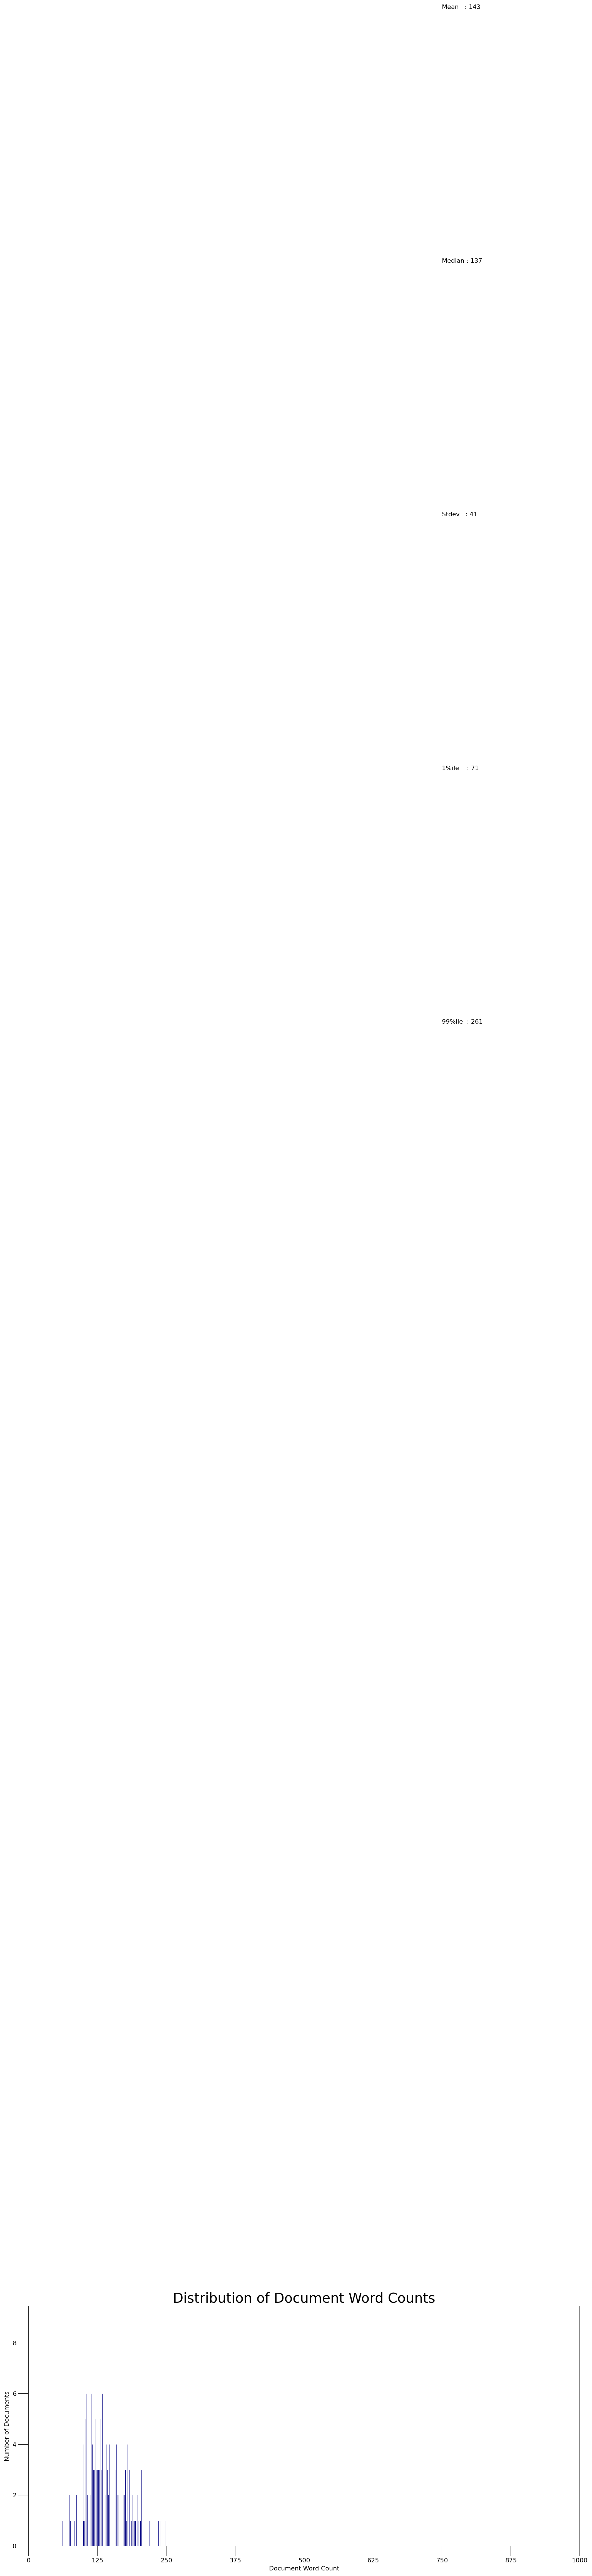

In [ ]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

/tmp/ipython-input-1039900307.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
/tmp/ipython-input-1039900307.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
/tmp/ipython-input-1039900307.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
/tmp/ipython-input-1039900307.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(doc_lens,

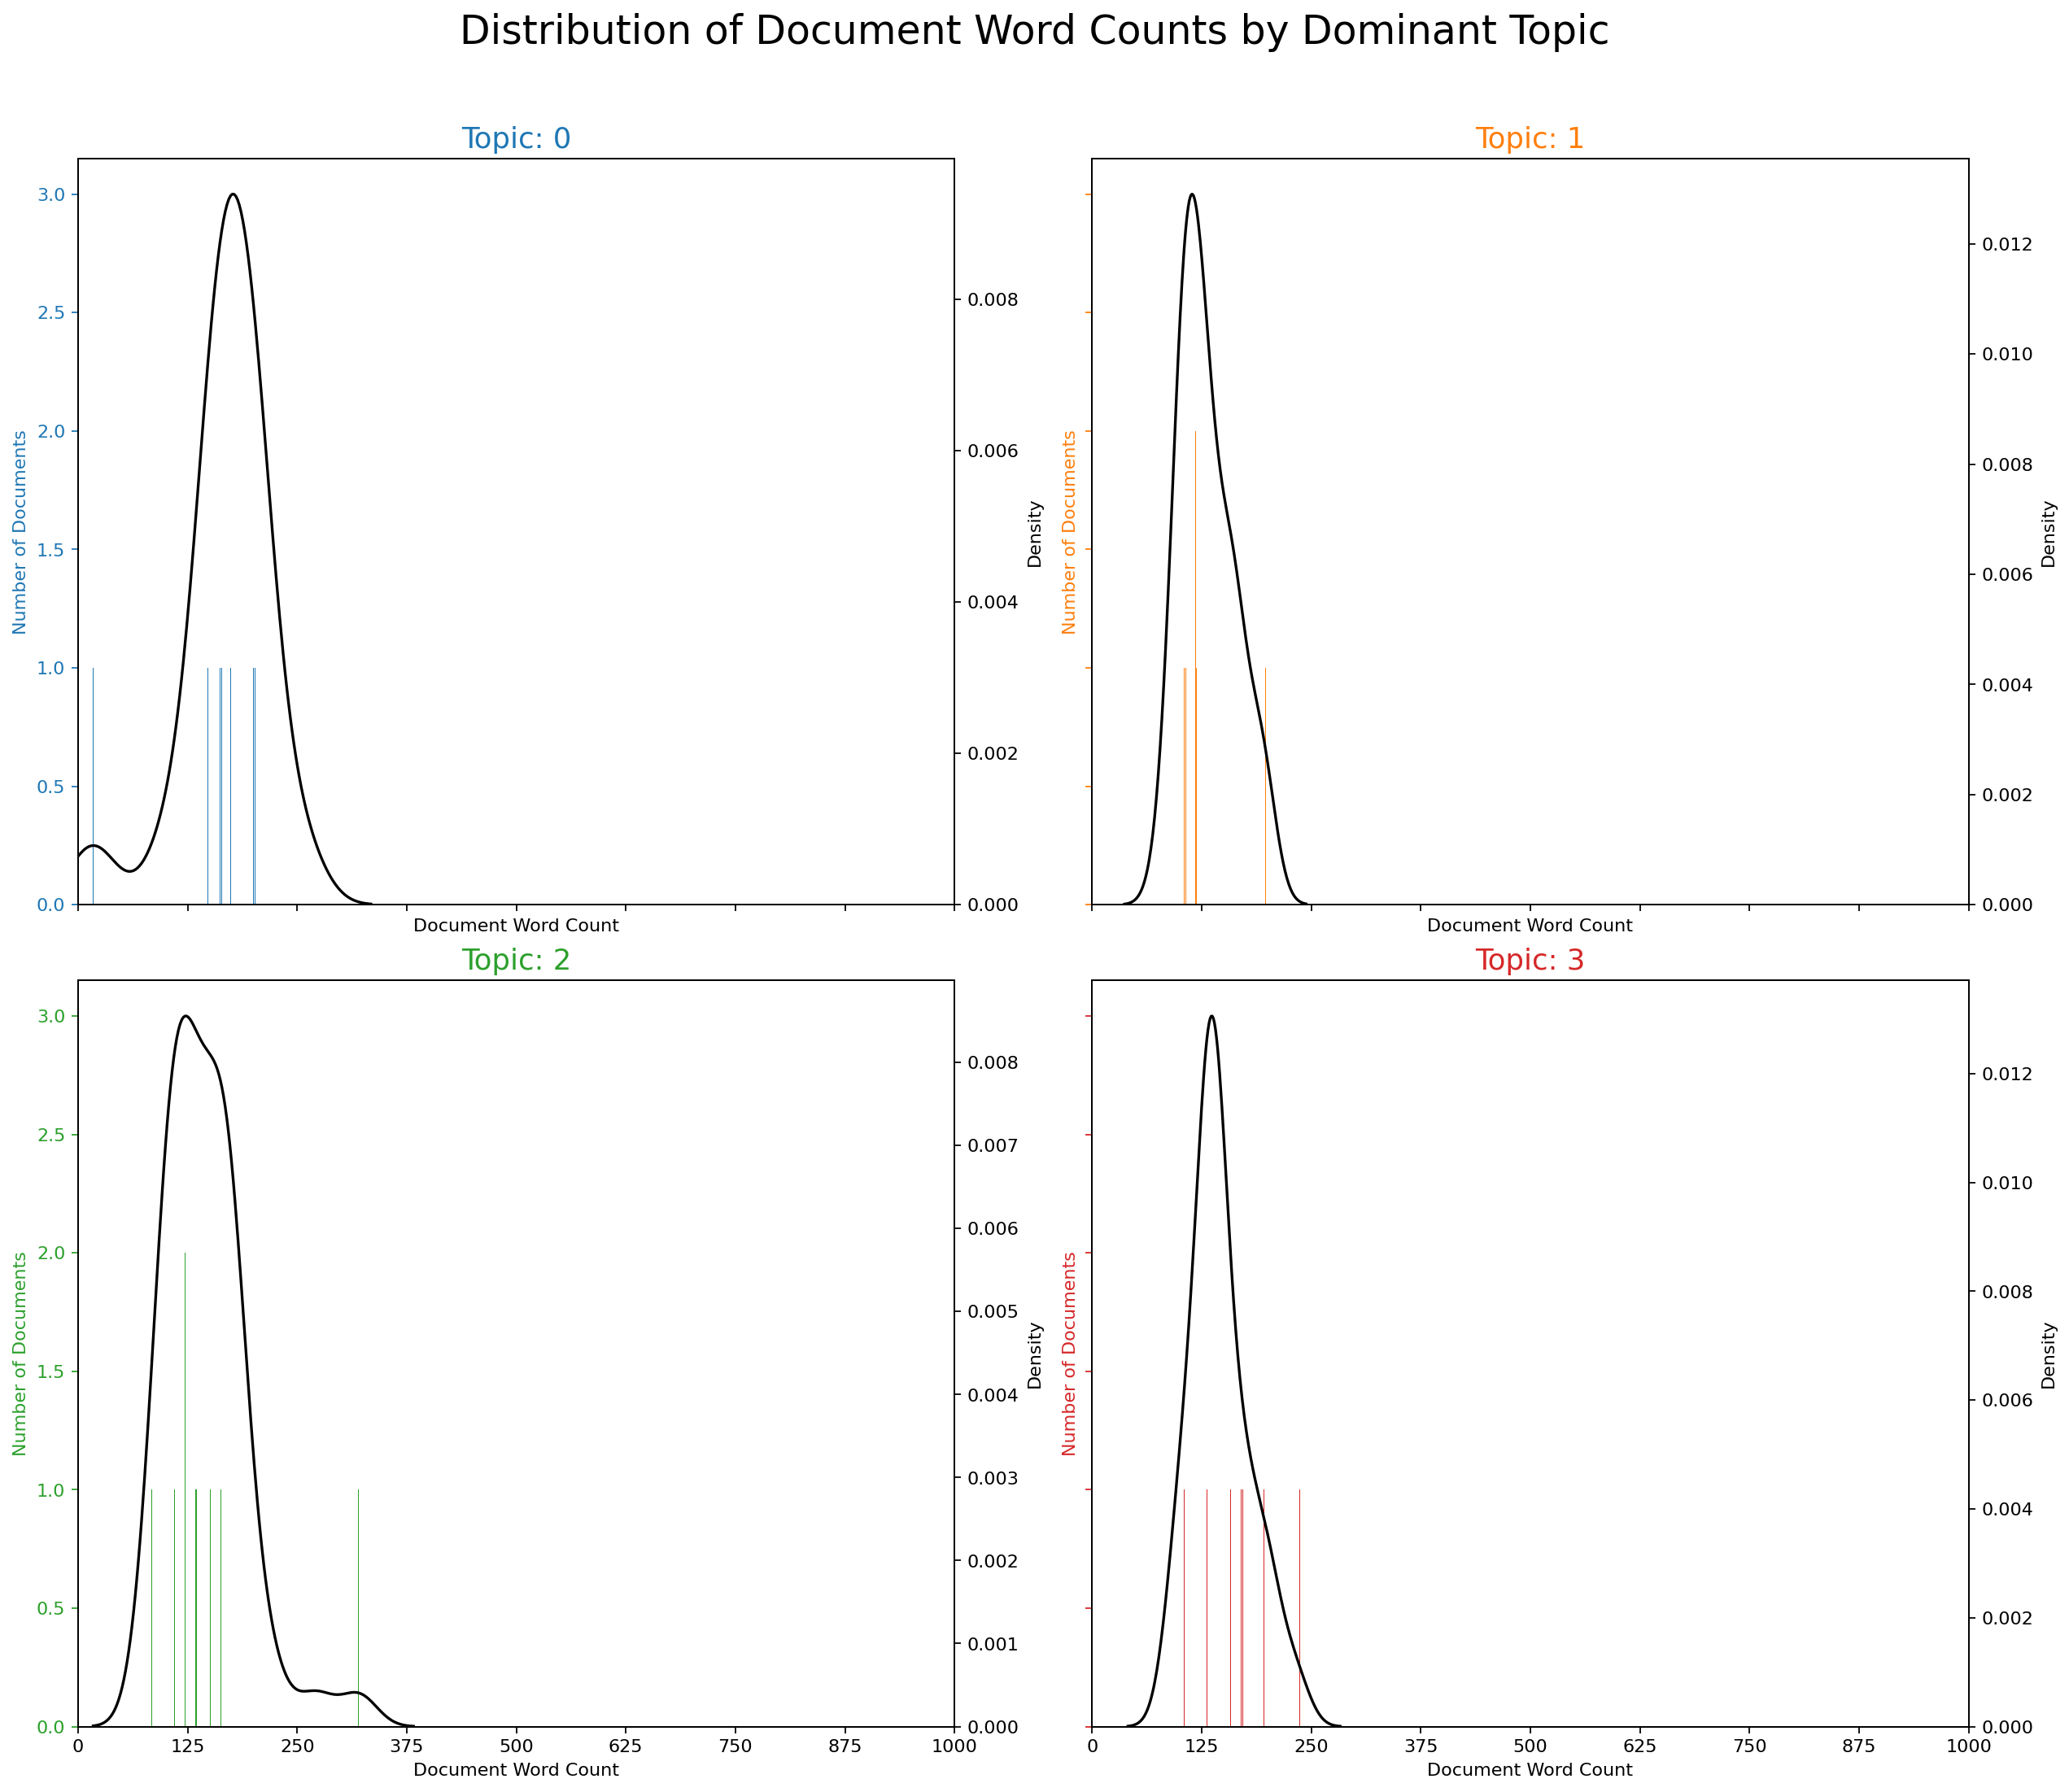

In [ ]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

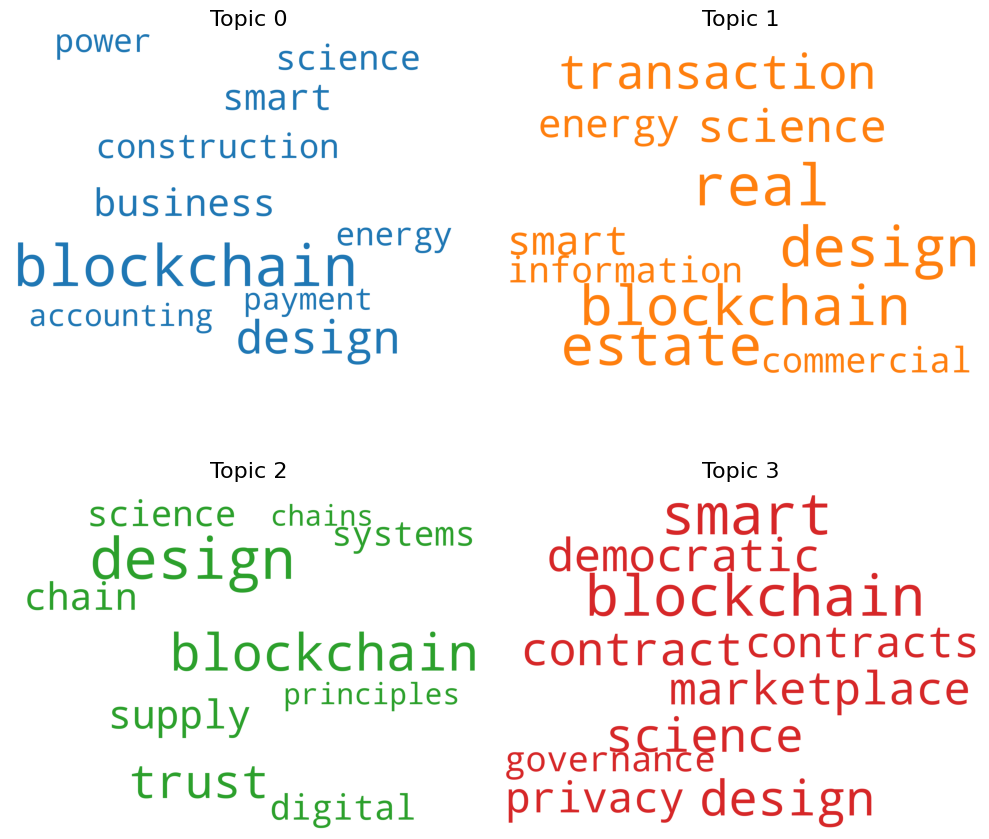

In [ ]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

/tmp/ipython-input-2397584749.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/tmp/ipython-input-2397584749.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


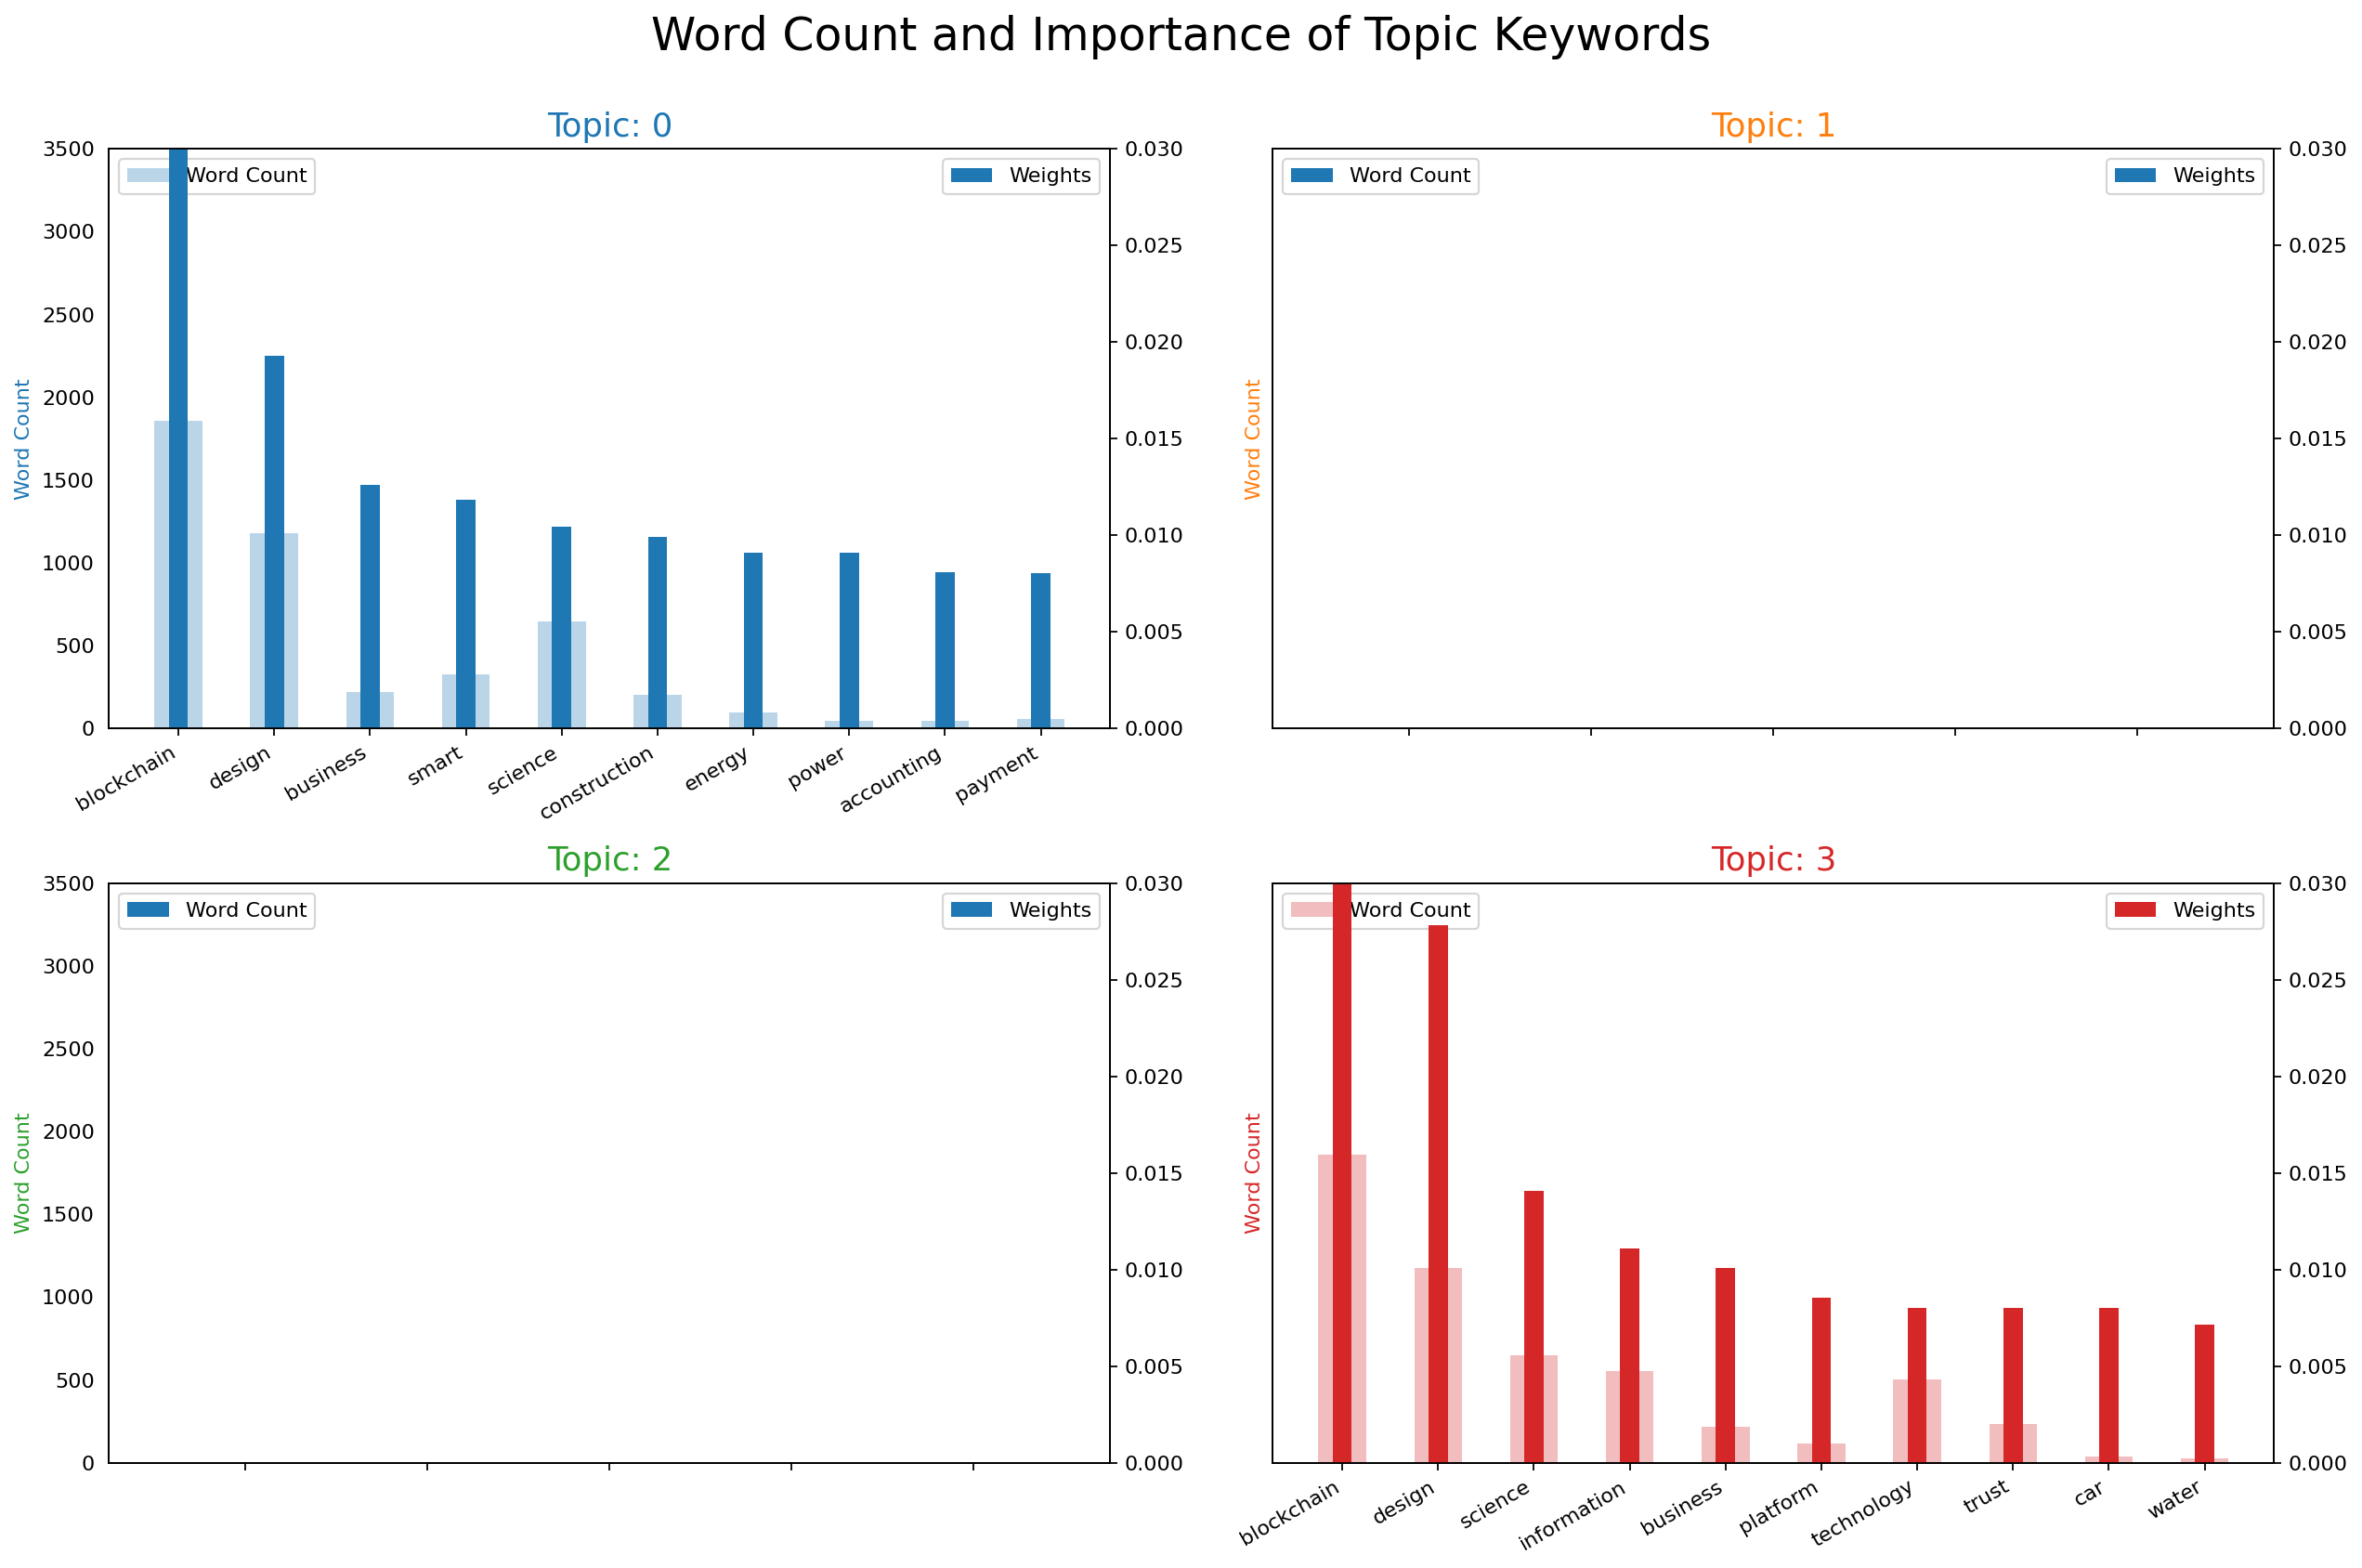

In [ ]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_words for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)
plt.show()

In [ ]:
data_text['text'] = data_text.apply(lambda row: ' '.join(row.astype(str)), axis=1)
data_text.head()

,Title,Abstract,Author Keywords,Index Keywords,text
0,Overcoming the Data Transparency Trade-Off: Designing a Blockchain-Based Delivery Invoice System...,Blockchain’s inherent characteristics render it a promising solution in collaborative supply cha...,Blockchain technology; Construction industry; Data transparency; Delivery invoices; Supply chain...,NaN,Overcoming the Data Transparency Trade-Off: Designing a Blockchain-Based Delivery Invoice System...
1,Blockchain-based digital rights management systems: Design principles for the music industry,Initially designed to protect intellectual property (IP) of digitalized information goods such a...,Blockchain; Decentralization; Design principles; Design science research; Digital rights managem...,NaN,Blockchain-based digital rights management systems: Design principles for the music industry Ini...
2,Blockchain-based digital product passport: design principles and demonstration,Digital product passports (DPPs) will become a reality for several regulated products in Europe....,blockchain; circular manufacturing; circular supply chain; Digital product passport; textile ind...,Supply chains; Block-chain; Circular manufacturing; Circular supply chain; Design Principles; De...,Blockchain-based digital product passport: design principles and demonstration Digital product p...
3,Toward Seamless Mobility-as-a-Service: Providing Multimodal Mobility Through Digital Wallets,"With growing awareness of sustainability and convenience expectations, customers are increasingl...",Coopetition; Digital identity; Digital wallet; MaaS; Self-sovereign identity,NaN,Toward Seamless Mobility-as-a-Service: Providing Multimodal Mobility Through Digital Wallets Wit...
4,"SCeFSTA: Smart Contract enabled Fair, Secure, and Transparent Auction for Healthcare Transportation","The healthcare transport sector has progressed considerably in recent years, yet it continues to...",NaN,Blockchain; Cost effectiveness; Distributed ledger; Health care; Redundancy; Block-chain; Cost e...,"SCeFSTA: Smart Contract enabled Fair, Secure, and Transparent Auction for Healthcare Transportat..."
